In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import ast
import glob
import re
import sys
import os
from subprocess import call
from shutil import copyfile, move
from tqdm import tqdm_notebook
from datetime import datetime
from datetime import timedelta
import time
import urllib.request
from itertools import islice
import math
from PIL import Image

import my_cosine_similarity as cs

Using TensorFlow backend.


In [2]:
now = datetime.now()
date=now.strftime("%d-%m-%Y")

thedir='/Users/bsalmon/BrettSalmon/data_science/Insight/goodriddance/scraping/'
cityname='Los Angeles'
city=cityname.lower().replace(' ','_')
item='couch'

In [3]:
offerup_df=pd.read_csv(thedir+'offerup/'+city+'/fiducial_'+item+'.csv', index_col='id')
craigslist_df=pd.read_csv(thedir+'craigslist/'+city+'/fiducial_'+item+'.csv', index_col='id')
sold_df=pd.read_csv(thedir+'offerup/'+city+'/all_'+item+'_sold.csv', index_col='id')

imgdir = thedir+'craigslist/'+city+'/'+item+'_images/'
images_in_dir = os.listdir(imgdir)
import shutil
for i in images_in_dir:
    if not int(i[0:-4]) in craigslist_df.index:
        shutil.move(imgdir+i,thedir+'craigslist/'+city+'/old_'+item+'_images/')

In [255]:
isold=41
soldid= int(os.listdir(thedir+'offerup/'+city+'/'+item+'_images/sold/')[isold][0:-4])
input_file = (thedir+'offerup/'+city+'/'+item+'_images/sold/'+
              os.listdir(thedir+'offerup/'+city+'/'+item+'_images/sold/')[isold])
print(sold_df.loc[soldid,'price'])

50.0


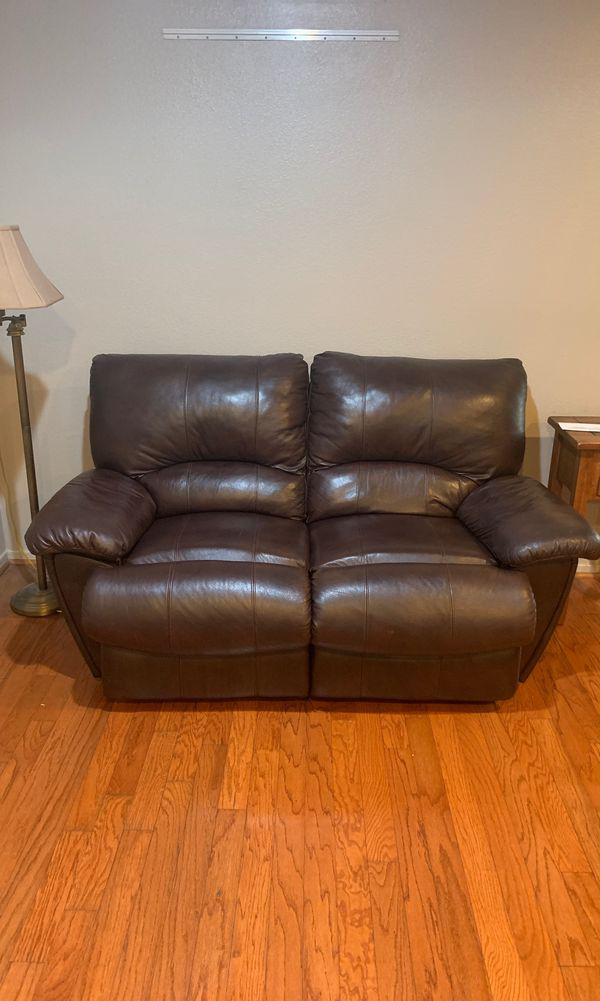

In [256]:
im = Image.open(input_file)
im

In [257]:
soldid= int(os.listdir(thedir+'offerup/'+city+'/'+item+'_images/sold/')[isold][0:-4])

input_file = (thedir+'offerup/'+city+'/'+item+'_images/sold/'+
              os.listdir(thedir+'offerup/'+city+'/'+item+'_images/sold/')[isold])
(offerup_image_paths,offerup_image_ids,
 offerup_cs) = cs.run(item, city, thedir+'offerup/', 'offerup',
                      input_file=input_file,first=False, topn=20)
(craigslist_image_paths,craigslist_image_ids, 
 craigslist_cs) = cs.run(item, city, thedir+'craigslist/', 'craigslist',
                         input_file=input_file,first=False, topn=20)

(sold_image_paths,sold_image_ids, 
 sold_css) = cs.run(item, city, thedir+'offerup/', 'offerup',
                    sold=True,input_file=input_file,first=False, topn=20)

offerup_prices=[]
offerup_days=[]
offerup_imgurl=[]

craigslist_prices=[]
craigslist_days=[]
craigslist_imgurl=[]

for i in range(len(offerup_image_ids)):
    offerup_prices.append( int(offerup_df.loc[offerup_image_ids[i],'price']) )
    offerup_days.append(offerup_df.loc[offerup_image_ids[i],'time_since_posting'])
    offerup_imgurl.append(offerup_df.loc[offerup_image_ids[i],'imgurl'])

    craigslist_prices.append( int(craigslist_df.loc[craigslist_image_ids[i],'price']) )
    craigslist_days.append(craigslist_df.loc[craigslist_image_ids[i],'time_since_posting'])
    craigslist_imgurl.append(craigslist_df.loc[craigslist_image_ids[i],'imgurl'])
offerup_prices=np.array(offerup_prices)
offerup_days=np.array(offerup_days)
craigslist_prices=np.array(craigslist_prices)
craigslist_days=np.array(craigslist_days)

%% You already have the image features in hand-- loading them from disk.
Loading features...
/Users/bsalmon/BrettSalmon/data_science/Insight/goodriddance/scraping/offerup/los_angeles/couch_images/sold/695115870.jpg
%% That was fast! Applying cosine similarity and finding images
%% Cosine similarity complete. Matched images are in myflask/static/matches/offerup
%% You already have the image features in hand-- loading them from disk.
Loading features...
/Users/bsalmon/BrettSalmon/data_science/Insight/goodriddance/scraping/offerup/los_angeles/couch_images/sold/695115870.jpg
%% That was fast! Applying cosine similarity and finding images
%% Cosine similarity complete. Matched images are in myflask/static/matches/craigslist
%% You already have the image features in hand-- loading them from disk.
Loading features...
/Users/bsalmon/BrettSalmon/data_science/Insight/goodriddance/scraping/offerup/los_angeles/couch_images/sold/695115870.jpg
%% That was fast! Applying cosine similarity and finding

In [258]:
from astropy.stats import sigma_clip
from scipy import stats

def final_answer(offerup_prices,offerup_days, craigslist_prices,craigslist_days):
    craigslist_filter = sigma_clip(craigslist_prices, sigma=2, maxiters=5)
    offerup_filter = sigma_clip(offerup_prices, sigma=2, maxiters=5)

    slope, intercept, r_value, p_value, std_err = stats.linregress(offerup_days[~offerup_filter.mask], 
                                                                   offerup_prices[~offerup_filter.mask])
    offerup_slope = slope
    offerup_intercept = intercept
    offerup_pvalue = p_value

    slope, intercept, r_value, p_value, std_err = stats.linregress(craigslist_days[~craigslist_filter.mask], 
                                                                   craigslist_prices[~craigslist_filter.mask])
    craigslist_slope = slope
    craigslist_intercept = intercept
    craigslist_pvalue = p_value

    sites = ['offerup', 'craigslist']

    craigslist_sigclip_prices= craigslist_prices[~craigslist_filter.mask]
    craigslist_sigclip_days= craigslist_days[~craigslist_filter.mask]

    offerup_sigclip_prices= offerup_prices[~offerup_filter.mask]
    offerup_sigclip_days= offerup_days[~offerup_filter.mask]


    early_means = [np.mean(craigslist_sigclip_prices[craigslist_sigclip_days < 2]), 
                   np.mean(offerup_sigclip_prices[offerup_sigclip_days < 2])]

    early_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days < 2]),
                 np.std(craigslist_sigclip_prices[craigslist_sigclip_days < 2])]

    late_means =[np.mean(offerup_sigclip_prices[offerup_sigclip_days >= 2]), 
                 np.mean(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]
    late_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days >= 2]),
                np.std(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]

    early_result = [sites[np.argmax( np.array(early_means)/np.array(early_std) )], np.mean(early_means)]
    late_result = [sites[np.argmax( np.array(late_means)/np.array(late_std))], np.mean(late_means)]
    return early_result, late_result

In [259]:
early_result, late_result = final_answer(offerup_prices,offerup_days, craigslist_prices,craigslist_days)

/Users/bsalmon/anaconda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [260]:
early_result, late_result

(['craigslist', 146.33088235294116], ['offerup', 122.22222222222223])

In [261]:
craigslist_filter = sigma_clip(craigslist_prices, sigma=2, maxiters=5)
offerup_filter = sigma_clip(offerup_prices, sigma=2, maxiters=5)

slope, intercept, r_value, p_value, std_err = stats.linregress(offerup_days[~offerup_filter.mask], 
                                                               offerup_prices[~offerup_filter.mask])
offerup_slope = slope
offerup_intercept = intercept
offerup_pvalue = p_value

slope, intercept, r_value, p_value, std_err = stats.linregress(craigslist_days[~craigslist_filter.mask], 
                                                               craigslist_prices[~craigslist_filter.mask])
craigslist_slope = slope
craigslist_intercept = intercept
craigslist_pvalue = p_value

sites = ['offerup', 'craigslist']

craigslist_sigclip_prices= craigslist_prices[~craigslist_filter.mask]
craigslist_sigclip_days= craigslist_days[~craigslist_filter.mask]

offerup_sigclip_prices= offerup_prices[~offerup_filter.mask]
offerup_sigclip_days= offerup_days[~offerup_filter.mask]


early_means = [np.mean(offerup_sigclip_prices[offerup_sigclip_days < 2]),
               np.mean(craigslist_sigclip_prices[craigslist_sigclip_days < 2])]

early_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days < 2]),
             np.std(craigslist_sigclip_prices[craigslist_sigclip_days < 2])]

late_means =[np.mean(offerup_sigclip_prices[offerup_sigclip_days >= 2]), 
             np.mean(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]
late_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days >= 2]),
            np.std(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]

early_result = [sites[np.argmax( np.array(early_means)/np.array(early_std) )], np.mean(early_means)]
late_result = [sites[np.argmax( np.array(late_means)/np.array(late_std))], np.mean(late_means)]


/Users/bsalmon/anaconda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in true_divide


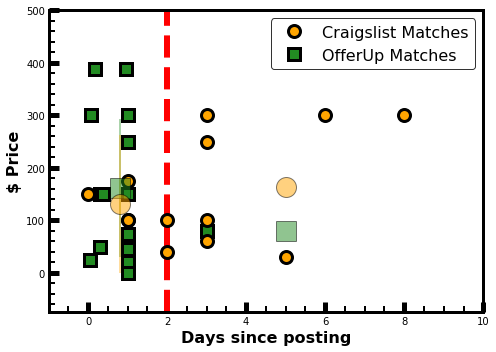

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(1,1,1)

ax.plot(craigslist_days[~craigslist_filter.mask], 
        craigslist_prices[~craigslist_filter.mask], 
        'o', ms=12, mec='k', mew=3, color='orange',
       label='Craigslist Matches', zorder=3)

ax.plot(offerup_days[~offerup_filter.mask], 
        offerup_prices[~offerup_filter.mask], 
        's', ms=12, mec='k', mew=3, color='forestgreen',
       label='OfferUp Matches', zorder=2)

if 0:
    ax = sns.regplot(x=offerup_days[~offerup_filter.mask], 
                     y=offerup_prices[~offerup_filter.mask], 
                     color="forestgreen")#, ci=95)
    ax = sns.regplot(x=craigslist_days[~craigslist_filter.mask], 
                     y=craigslist_prices[~craigslist_filter.mask], 
                     color="orange")#,ci=95)

#ax.axhline(y=sold_df.loc[soldid,'price'], color='red', lw=6)
ax.axvline(x=2,ls='--', color='red', lw=6)


#for i in np.array(sold_df.loc[np.array(sold_image_ids)[sold_css >0.5],'price']):
#    ax.axhline(y=i,color='blue', lw=1)

ax.set_xlabel('Days since posting', fontsize=16, fontweight='bold')
ax.set_ylabel('$ Price', fontsize=16, fontweight='bold')

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)    

ax.xaxis.set_tick_params(width=3, length=10, which='major', direction='in')
ax.yaxis.set_tick_params(width=3, length=10, which='major', direction='in')
ax.xaxis.set_tick_params(width=2, length=6, which='minor', direction='in')
ax.yaxis.set_tick_params(width=2, length=6, which='minor', direction='in')

ax.xaxis.set_tick_params(width=5)
ax.yaxis.set_tick_params(width=5)

ax.minorticks_on()
        
ax.set_ylim(-75,500)
ax.set_xlim(-1,10)

ax.legend(fontsize=16, edgecolor='k')

# OfferUp
ax.errorbar([0.8],[early_means[0]], yerr=[early_std], fmt='s', ms=20,
           color='forestgreen', alpha=0.5,mec='k', zorder=10)
ax.plot([0.8],[early_means[0]], '',color='none', mec='red', ms=20)

# Craigslist
ax.errorbar([0.8],[early_means[1]], yerr=[early_std], fmt='o', ms=20,
           color='orange', alpha=0.5,mec='k', zorder=10)

# OfferUp
ax.errorbar([5],[late_means[0]], yerr=[late_std], fmt='s', ms=20,
           color='forestgreen', alpha=0.5,mec='k', zorder=10)
# Craigslist
ax.errorbar([5],[late_means[1]], yerr=[late_std], fmt='o', ms=20,
           color='orange', alpha=0.5,mec='k', zorder=10)


fig.tight_layout()
fig.savefig('/Users/bsalmon/Desktop/method.jpg')

0.693818841943437

In [231]:

sites = ['offerup', 'craigslist']

craigslist_sigclip_prices= craigslist_prices[~craigslist_filter.mask]
craigslist_sigclip_days= craigslist_days[~craigslist_filter.mask]

offerup_sigclip_prices= offerup_prices[~offerup_filter.mask]
offerup_sigclip_days= offerup_days[~offerup_filter.mask]


early_means = [np.mean(craigslist_sigclip_prices[craigslist_sigclip_days < 2]), 
               np.mean(offerup_sigclip_prices[offerup_sigclip_days < 2])]

early_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days < 2]),
             np.std(craigslist_sigclip_prices[craigslist_sigclip_days < 2])]

late_means =[np.mean(offerup_sigclip_prices[offerup_sigclip_days >= 2]), 
             np.mean(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]
late_std = [np.std(offerup_sigclip_prices[offerup_sigclip_days >= 2]),
            np.std(craigslist_sigclip_prices[craigslist_sigclip_days >= 2])]

In [232]:
early_result = sites[np.argmax( np.array(early_means)/np.array(early_std) )], np.mean(early_means)
late_result = sites[np.argmax( np.array(late_means)/np.array(late_std))], np.mean(late_means)

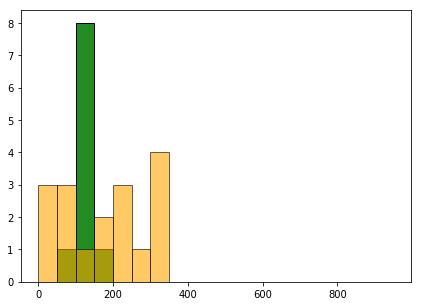

In [359]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(1,1,1)
ax.hist(offerup_prices[~offerup_filter.mask], ec='k',color='forestgreen',bins=np.arange(0,1000,50));
ax.hist(craigslist_prices[~craigslist_filter.mask], ec='k', color='orange',bins=np.arange(0,1000,50), alpha=0.6);

In [366]:
%matplotlib inline

im = Image.open(input_file)

In [367]:
matched_offerup_paths = [thedir+'offerup/'+city+'/'+item+'_images/'+i for i in offerup_image_paths]
matched_craigslist_paths = [thedir+'craigslist/'+city+'/'+item+'_images/'+i for i in craigslist_image_paths]

In [368]:
matched_craigslist_images=[]
for i in matched_craigslist_paths:
    matched_craigslist_images.append(Image.open(i))

In [369]:
matched_offerup_images=[]
for i in matched_offerup_paths:
    matched_offerup_images.append(Image.open(i))

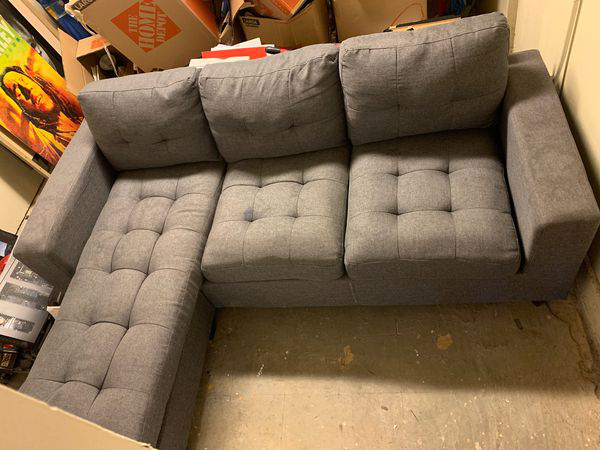

In [370]:
im

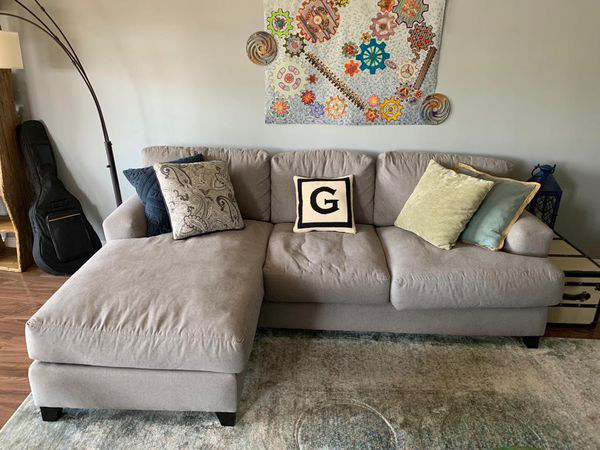

In [376]:
si=-4
Image.open(thedir+'offerup/'+city+'/'+item+'_images/sold/'
           +str(np.array(sold_image_ids)[sold_css >0.1][si])+'.jpg')

0.549245 100


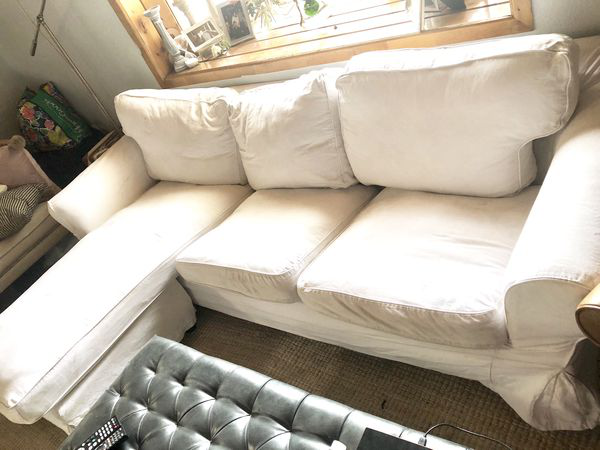

In [386]:
ii=5
print(offerup_cs[ii],offerup_prices[ii])
matched_offerup_images[ii]

0.49531132 95


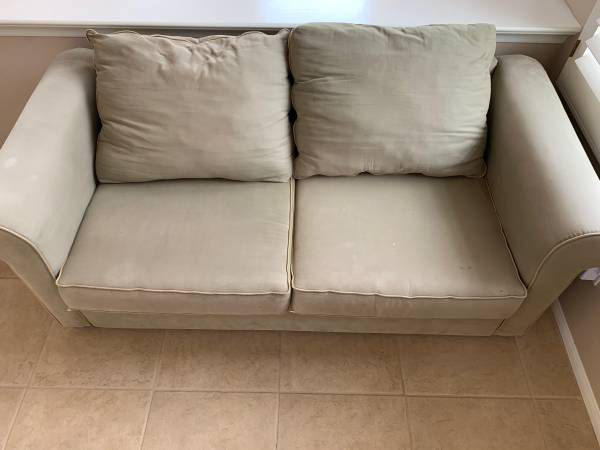

In [383]:
print(craigslist_cs[ii], craigslist_prices[ii])
matched_craigslist_images[ii]

In [81]:
#craigslist_cs #[::-1]
offerup_cs

array([0.47226548, 0.36303794, 0.4847106 , ..., 0.51861405, 0.34279925,
       0.17972383], dtype=float32)

In [45]:
craigslist_cs

array([0.5249406 , 0.5249406 , 0.5249406 , ..., 0.5249405 , 0.4602841 ,
       0.55905855], dtype=float32)

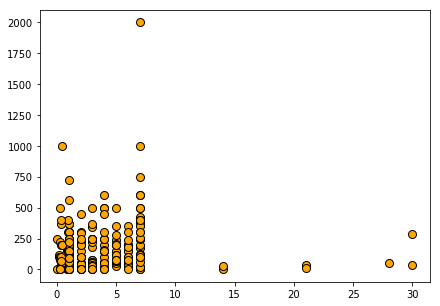

In [95]:
fig = plt.figure(figsize=[7,5])
ax = fig.add_subplot(1,1,1)

ax.plot(sold_df['time_since_posting'], sold_df['price'],
        'o', ms=8, mec='k', mew=1, color='orange')

In [64]:
#for i in offerup_image_ids:
#    print(offerup_df[offerup_df.index == i]['url'])

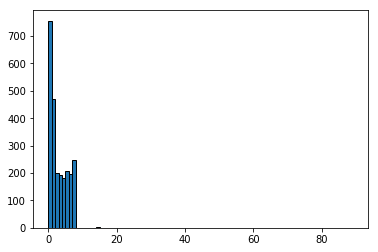

In [72]:
plt.hist(offerup_df['time_since_posting'], ec='k',bins=np.arange(0,90,1));